#### Order of Operations ####

1.) Define the business question that you would like to answer with data - *Time series forecasting*

2.) Define the ideal data set (ie the data set that you would collect if time and money were no object) - *A dataset that contains 3+ years of daily time series data.*   

3.) Determine what data you can access - *TM_US_incremental_web_order_raw_data.xlsx*

4.) [Obtain the data](#obtain)
    - Read in the larger dataset
    - Trim the data down to what is needed for modeling

5.) [Clean the data](#clean)
    - Correct datatypes
    - Address missing values

6.) [Create validation dataset](#validation)
    - Create the validation or "holdout" dataset

7.) [Naive Forecast (baseline)](#baseline)
    - Observation from previous time step is used as the prediction for the observation at the next time step to establish a baseline of performance
    - Naive root mean squared error (RMSE)

8.) [Exploratory data analysis](#explore)
    - Univariate Analysis - summary statistics

9.) [Variable transformation](#transformation)
    - Variable transformation

10.) [Outlier treatment](#outlier)
    - Outlier treatment

11.) [Variable creation](#variable)
    - Variable creation

12.) [Statistical prediction/modeling](#model) (perform statistical prediction or modeling to answer the business question)
    - Time Series forecasting (prediction)

13.) [Interpret results](#interpret) (so that you can tell people in plain language what the statistical models or predictions mean)

14.) Challenge results (explain to people what the potential failings of the model are so they are able to make informed decisions)

15.) Synthesize/write up results telling a story about the data that attempts to answer the question

16.) Create reproducible code

#### Import Modules ####

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# show plots in the notebook
%matplotlib inline
# default notebook setup
MAX_ROWS = 10
pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.options.display.float_format = '{:.3f}'.format
sns.set_style("whitegrid")
sns.set_context("paper")

# Helper fun to pretty print dataframes
def print_full(x):
    pd.set_option('display.max_rows', len(x))
    print(x)
    pd.reset_option('display.max_rows')

#### Obtain the data <a id="obtain"></a>

In [2]:
# Read in the data
df = pd.read_excel('TM_US_incremental_web_order_raw_data.xlsx', sheetname=0, index_col=None)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97 entries, 0 to 96
Data columns (total 13 columns):
Week                      97 non-null datetime64[ns]
DisplayVisits             97 non-null int64
SEOVisits                 97 non-null int64
SEMVisits                 97 non-null int64
Bounces                   97 non-null int64
CartStarts                97 non-null int64
WebOrderSubmissions       97 non-null int64
TotalVisits               97 non-null int64
Entries                   97 non-null int64
UniqueVisitors            97 non-null int64
BounceRate                97 non-null float64
CartStartRate             97 non-null float64
WebOrderSubmissionRate    97 non-null float64
dtypes: datetime64[ns](1), float64(3), int64(9)
memory usage: 9.9 KB


In [3]:
# Trim the dataframe down to the columns we need for the modeling
df = df[['Week','TotalVisits']]
df.head()

,Week,TotalVisits
0,2015-01-04,10403800
1,2015-01-11,10699393
2,2015-01-18,10522657
3,2015-01-25,10815097
4,2015-02-01,10496132


#### Clean the data <a id="clean"></a>

In [4]:
# Change the data type and format
df['TotalVisits'] = df['TotalVisits'].astype(int)

# Dataset now has the correct datatypes and format
df.info() # prints info on dataframe

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97 entries, 0 to 96
Data columns (total 2 columns):
Week           97 non-null datetime64[ns]
TotalVisits    97 non-null int32
dtypes: datetime64[ns](1), int32(1)
memory usage: 1.2 KB


In [5]:
# Run function to find missing values in columns and rows
def num_missing(x):
    return sum(x.isnull())

# Applying per column:
print("Missing values per column:")
print(df.apply(num_missing, axis=0)) #axis=0 defines that function is to be applied on each column

# Applying per row:
print("\nMissing values per row:")
print(df.apply(num_missing, axis=1).head()) #axis=1 defines that function is to be applied on each row

Missing values per column:
Week           0
TotalVisits    0
dtype: int64

Missing values per row:
0    0
1    0
2    0
3    0
4    0
dtype: int64


In [6]:
# Prophet has no problem with missing data. If you set their values to NA in the history but leave the dates in future
# then Prophet will give you a prediction for their values.

# df.loc[(df['ds'] > '2010-01-01') & (df['ds'] < '2011-01-01'), 'y'] = None

#### Create validation dataset <a id="validation"></a>

In [7]:
# Create the dataset and validation dataframes

split_point = (len(df) - round((len(df)*.20)))-1 # The size of the test set is typically 20% of the total sample (should be at least as large as the maximum forecast horizon required)
dataset, validation = df[0:split_point], df[split_point:]
val_per = len(validation) / len(df) * 100
print('Dataset %d rows, Validation %d rows (%.1f percent of total data)' % (len(dataset), len(validation), val_per))
dataset.to_csv('dataset.csv', index=False) # dataset
validation.to_csv('validation.csv', index=False) # validation
dataset.head()

Dataset 77 rows, Validation 20 rows (20.6 percent of total data)


,Week,TotalVisits
0,2015-01-04,10403800
1,2015-01-11,10699393
2,2015-01-18,10522657
3,2015-01-25,10815097
4,2015-02-01,10496132


#### Create Baseline (Naive Forecast) <a id="baseline"></a>

In [8]:
# load data into a dataframe
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
dataset = pd.read_csv('dataset.csv', parse_dates=[0], index_col='Week', date_parser=dateparse)
dataset.head()

,TotalVisits
Week,
2015-01-04,10403800
2015-01-11,10699393
2015-01-18,10522657
2015-01-25,10815097
2015-02-01,10496132


In [9]:
#Confirm data has time object as index
print(dataset.index)

DatetimeIndex(['2015-01-04', '2015-01-11', '2015-01-18', '2015-01-25',
               '2015-02-01', '2015-02-08', '2015-02-15', '2015-02-22',
               '2015-03-01', '2015-03-08', '2015-03-15', '2015-03-22',
               '2015-03-29', '2015-04-05', '2015-04-12', '2015-04-19',
               '2015-04-26', '2015-05-03', '2015-05-10', '2015-05-17',
               '2015-05-24', '2015-05-31', '2015-06-07', '2015-06-14',
               '2015-06-21', '2015-06-28', '2015-07-05', '2015-07-12',
               '2015-07-19', '2015-07-26', '2015-08-02', '2015-08-09',
               '2015-08-16', '2015-08-23', '2015-08-30', '2015-09-06',
               '2015-09-13', '2015-09-20', '2015-09-27', '2015-10-04',
               '2015-10-11', '2015-10-18', '2015-10-25', '2015-11-01',
               '2015-11-08', '2015-11-15', '2015-11-22', '2015-11-29',
               '2015-12-06', '2015-12-13', '2015-12-20', '2015-12-27',
               '2016-01-03', '2016-01-10', '2016-01-17', '2016-01-24',
      

In [10]:
# Create the performance measure functions
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

# function for root mean squared error (RMSE)
def rmse(ypred, ytrue):
    """ returns the root mean squared error"""
    return sqrt(mean_squared_error(ytrue, ypred))

# function for mean absolute percentage error (MAPE) 
def mape(ypred, ytrue):
    """ returns the mean absolute percentage error """
    if np.all(ytrue > 0): # ** Will not work if ytrue contains zeros **
        return np.mean(np.abs((ytrue - ypred) / ytrue)) * 100
    else:
        print('MAPE cannot be calculated. There are zeros in ytrue (one divided by zero issue)')

In [11]:
# Models will be evaluated using walk-forward validation. Observation from previous time step is used as the prediction for the observation at the next time step

# load data
series = dataset[[0]]
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    # predict
    yhat = history[-1] # Naive forecast to establish a baseline of performance
    predictions.append(yhat)
    # observation
    obs = test[i]
    history.append(obs)
    print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))
# report performance
print('RMSE: %.3f' % rmse(predictions, test)) # root mean squared error (RMSE) measures average error in the same units as original data
print('MAPE: %0.2f%%' % mape(predictions, test)) # mean absolute percentage error (MAPE) measures the size of the error in percentage terms.

>Predicted=10787112.000, Expected=10657990
>Predicted=10657990.000, Expected=9877758
>Predicted=9877758.000, Expected=9790377
>Predicted=9790377.000, Expected=9650213
>Predicted=9650213.000, Expected=8990243
>Predicted=8990243.000, Expected=9553317
>Predicted=9553317.000, Expected=9502191
>Predicted=9502191.000, Expected=10757491
>Predicted=10757491.000, Expected=10846623
>Predicted=10846623.000, Expected=11195422
>Predicted=11195422.000, Expected=10256376
>Predicted=10256376.000, Expected=9857894
>Predicted=9857894.000, Expected=9503049
>Predicted=9503049.000, Expected=9066213
>Predicted=9066213.000, Expected=8818364
>Predicted=8818364.000, Expected=8866741
>Predicted=8866741.000, Expected=8536369
>Predicted=8536369.000, Expected=8724974
>Predicted=8724974.000, Expected=9387870
>Predicted=9387870.000, Expected=9607860
>Predicted=9607860.000, Expected=9212392
>Predicted=9212392.000, Expected=10118937
>Predicted=10118937.000, Expected=9872095
>Predicted=9872095.000, Expected=10155122
>P

#### Exploratory data analysis <a id="explore"></a>

Stats on TotalVisits:

count         77.000
mean     9455658.883
std       784306.193
min      7553177.000
25%      8818364.000
50%      9460465.000
75%     10076208.000
max     11195422.000
Name: TotalVisits, dtype: float64

median--> 9460465.000
mode--> Series([], dtype: int64)
variance--> 615136204639.683
UCL--> 11024271.269
LCL--> 7887046.497
skewness--> 0.137
kurtosis--> -0.682



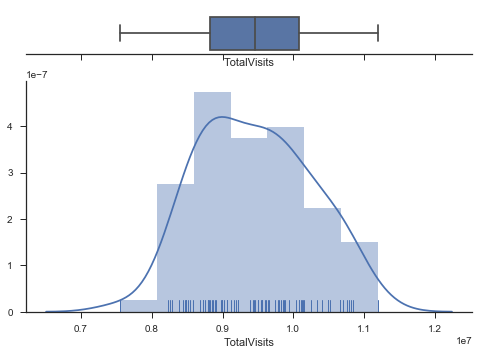

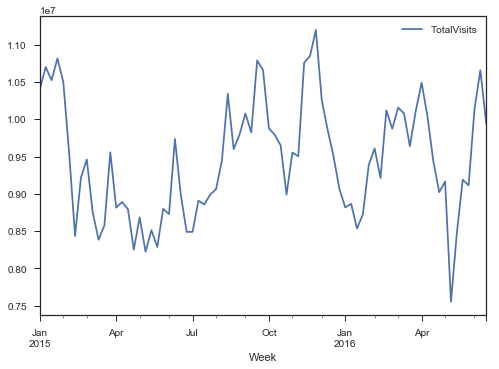

In [12]:
# Univariate Analysis - explore Central Tendency, Measure of Dispersion
c = dataset.columns[0] # Variable to analyze
df = dataset    # Dataframe variable is in
# Stat print out
print('Stats on {}:\n'.format(c))
print (df[c].describe())
men = df[c].mean()
mod = df[c].mode()
med = df[c].median(axis = 0)
var = df[c].var()
ske = df[c].skew()
kur = df[c].kurt()
std = df[c].std()
ucl = men + (std*2) # about 95 percent of the data values are within two standard deviations
lcl = men - (std*2) # about 95 percent of the data values are within two standard deviations
print('\nmedian--> {0:.3f}'.format(med))
print('mode--> {}'.format(mod))
print('variance--> {0:.3f}'.format(var))
print('UCL--> {0:.3f}'.format(ucl))
print('LCL--> {0:.3f}'.format(lcl))
print('skewness--> {0:.3f}'.format(ske))
print('kurtosis--> {0:.3f}\n'.format(kur))
# Seaborn graphs below
sns.set(style="ticks")
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
sns.boxplot(df[c].dropna(), ax=ax_box) # box
sns.distplot(df[c].dropna(), ax=ax_hist, kde=True, rug=True) #distr
ax_box.set(yticks=[])
sns.despine(ax=ax_hist)
sns.despine(ax=ax_box, left=True)
df.plot(y=c); # trend

#### Variable transformation <a id="transformation"></a>

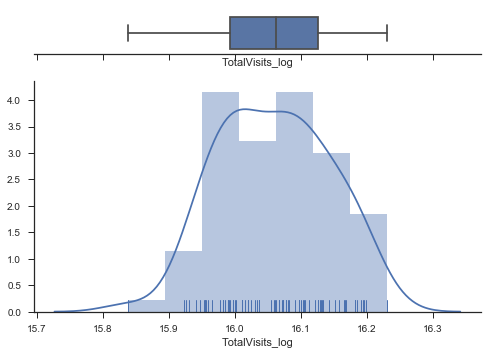

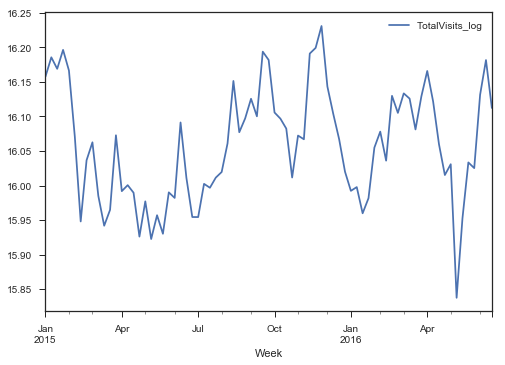

In [14]:
# Variable transformation (logarithm, square/cube)
# Logging converts multiplicative relationships to additive relationships, and by the same token it converts exponential (compound growth) trends to linear trends)

c = dataset.columns[0] # Variable to analyze
df = dataset    # Dataframe variable is in

# Remove any zeros (otherwise we get (-inf)
df.loc[df[c] == 0, c] = np.nan

# Drop NA
df.dropna(subset=[c], inplace=True) 

# Transform the WebOrderSubmissions to a log value
df[c+'_log'] = np.log(df[c])

c=c+'_log'
# Seaborn graphs below
sns.set(style="ticks")
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
sns.boxplot(df[c].dropna(), ax=ax_box) # box
sns.distplot(df[c].dropna(), ax=ax_hist, kde=True, rug=True) #distr
ax_box.set(yticks=[])
sns.despine(ax=ax_hist)
sns.despine(ax=ax_box, left=True)
df.plot(y=c); # trend

#### Outlier treatment <a id="outlier"></a>

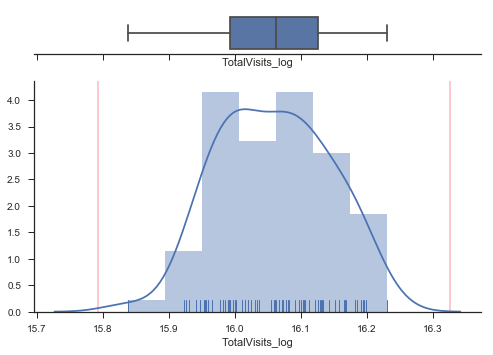

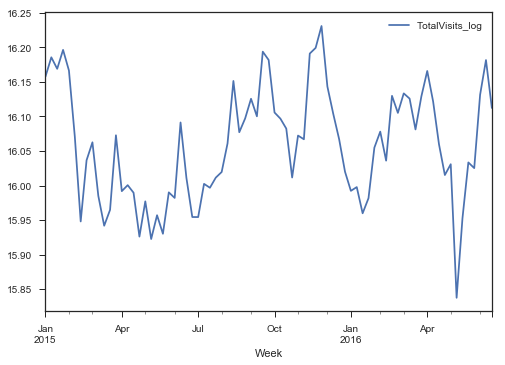

In [15]:
# Outlier treatment (univariate/multivariate w/ deletion, transformation, imputation, or treat separately)
# Prophet recommends addressing outliers in by changing them to NaNs

c = dataset.columns[1] # Variable to analyze
df = dataset    # Dataframe variable is in

# Calculate the min and max cuttoffs for detecting the outliers 
q75, q25 = np.percentile(df[c].dropna(), [75, 25])
iqr = q75 - q25
min = q25 - (iqr*1.5)    # Lower fence
max = q75 + (iqr*1.5)    # Upper fence

# Graph the outlier cutoffs
# Seaborn graphs below
sns.set(style="ticks")
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
plt.axvline(x=min, color='pink')    # Visualize the outlier cutoffs
plt.axvline(x=max, color='pink')    # Visualize the outlier cutoffs
sns.boxplot(df[c].dropna(), ax=ax_box) # box
sns.distplot(df[c].dropna(), ax=ax_hist, kde=True, rug=True) #distr
ax_box.set(yticks=[])
sns.despine(ax=ax_hist)
sns.despine(ax=ax_box, left=True)
df.plot(y=c); # trend

In [16]:
# Identify the outliers by creating a column and flagging those data points that are < min and > max 
df['Outlier'] = 0
df.loc[df[c] < min, 'Outlier'] = 1
df.loc[df[c] > max, 'Outlier'] = 1

In [17]:
# Create a mask of `Outlier` == 0 to get rid of Outliers
df = df[(df['Outlier'] == 0)]

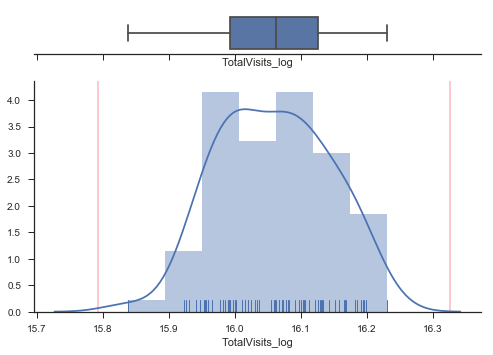

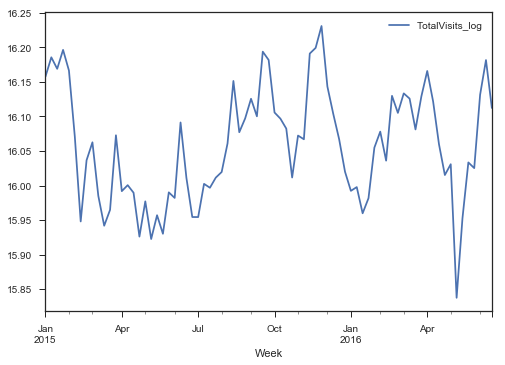

In [18]:
# Re-plot the data with the outliers removed
# Seaborn graphs below
sns.set(style="ticks")
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
plt.axvline(x=min, color='pink')    # Visualize the outlier cutoffs
plt.axvline(x=max, color='pink')    # Visualize the outlier cutoffs
sns.boxplot(df[c].dropna(), ax=ax_box) # box
sns.distplot(df[c].dropna(), ax=ax_hist, kde=True, rug=True) #distr
ax_box.set(yticks=[])
sns.despine(ax=ax_hist)
sns.despine(ax=ax_box, left=True)
df.plot(y=c); # trend

In [19]:
# Update df with df to remove outliers
dataset.update(df)
dataset = dataset.drop('Outlier', axis=1) # drop the outlier column
dataset.head()

,TotalVisits,TotalVisits_log
Week,,
2015-01-04,10403800.000,16.158
2015-01-11,10699393.000,16.186
2015-01-18,10522657.000,16.169
2015-01-25,10815097.000,16.196
2015-02-01,10496132.000,16.167


In [20]:
# Rename log column to 'y' and drop raw values column
dataset = dataset.drop('TotalVisits', axis=1)
dataset.columns = ['y']
dataset.head()

,y
Week,
2015-01-04,16.158
2015-01-11,16.186
2015-01-18,16.169
2015-01-25,16.196
2015-02-01,16.167


#### Stationary 

In [21]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=4,center=False).mean()
    rolstd = timeseries.rolling(window=4,center=False).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test: null hypothesis is that the series is not stationary
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

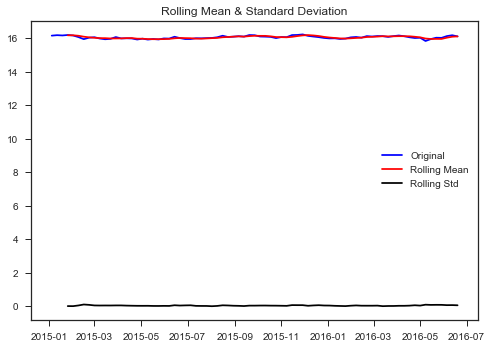

Results of Dickey-Fuller Test:
Test Statistic                -3.503
p-value                        0.008
#Lags Used                     0.000
Number of Observations Used   76.000
Critical Value (1%)           -3.519
Critical Value (5%)           -2.900
Critical Value (10%)          -2.587
dtype: float64


In [22]:
test_stationarity(dataset['y'])

In [23]:
# Make the time series stationary with either detrending, differencing, or seasonality

# def difference(dataset):
# ''' difference function'''
#     diff = list()
#     for i in range(1, len(dataset)):
#         value = dataset[i] - dataset[i - 1]
#         diff.append(value)
#     return Series(diff)


#### Modeling <a id="model"></a>

In [24]:
dataset.head()

,y
Week,
2015-01-04,16.158
2015-01-11,16.186
2015-01-18,16.169
2015-01-25,16.196
2015-02-01,16.167


In [25]:
dataset = dataset.reset_index()
dataset.rename(columns={'Week':'ds'}, inplace=True)
dataset.head()

,ds,y
0,2015-01-04,16.158
1,2015-01-11,16.186
2,2015-01-18,16.169
3,2015-01-25,16.196
4,2015-02-01,16.167


In [26]:
# Use fbprophet to forecast
import pystan
from fbprophet import Prophet

In [27]:
# Let's try to model holidays. Read in the excel file with the holidays listed
hhelper = pd.read_excel('holidays_helper.xlsx', sheetname=0, index_col=None)
hhelper.head()

,year,wk,name,date,sunday
0,2015,1,NYE,2015-01-01,2014-12-28
1,2015,4,MLK,2015-01-19,2015-01-18
2,2015,8,Washington,2015-02-16,2015-02-15
3,2015,14,Good Friday,2015-04-03,2015-03-29
4,2015,22,Memorial,2015-05-25,2015-05-24


In [28]:
hhelper.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 5 columns):
year      42 non-null int64
wk        42 non-null int64
name      42 non-null object
date      42 non-null datetime64[ns]
sunday    42 non-null datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(1)
memory usage: 1.7+ KB


In [29]:
# Account for holidays in the model. To capture the holidays, define a holiday dataframe with a datestamp and the description of the holiday:
holiday_df = pd.DataFrame({
  'holiday': 'fed_holiday',
  'ds': hhelper['sunday'],
  'lower_window': 0,
  'upper_window': 1
})
holiday_df.head()

,ds,holiday,lower_window,upper_window
0,2014-12-28,fed_holiday,0,1
1,2015-01-18,fed_holiday,0,1
2,2015-02-15,fed_holiday,0,1
3,2015-03-29,fed_holiday,0,1
4,2015-05-24,fed_holiday,0,1


In [30]:
dataset.head()

,ds,y
0,2015-01-04,16.158
1,2015-01-11,16.186
2,2015-01-18,16.169
3,2015-01-25,16.196
4,2015-02-01,16.167


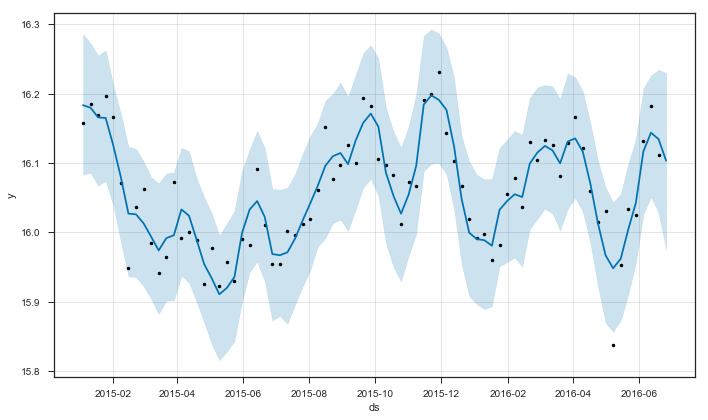

In [32]:
m1 = Prophet(growth='linear',
             changepoint_prior_scale=0.09,
             #n_changepoints=7,
             #changepoints= #List,
             #yearly_seasonality=boolean
             weekly_seasonality=False,
             mcmc_samples=500,
             holidays=holiday_df, # To use the holidays in the model, pass it to the model via the 'holidays' keyword
             holidays_prior_scale=4,
             seasonality_prior_scale=5,
             uncertainty_samples=500,
             interval_width=0.95,
            ).fit(dataset)
future1 = m1.make_future_dataframe(periods=1, freq='W-SUN')
forecast1 = m1.predict(future1)
m1.plot(forecast1); # New forecast based on model that includes holidays

In [33]:
dataset.tail()

,ds,y
72,2016-05-22,16.033
73,2016-05-29,16.025
74,2016-06-05,16.131
75,2016-06-12,16.182
76,2016-06-19,16.112


In [34]:
#16.108
a = forecast1.iloc[-1:, -1:]
print(a)

     yhat
77 16.103


In [ ]:
i = 1
test.iloc[i-1:i]

In [97]:
# Models will be evaluated using walk-forward validation. Observation from previous time step is used as the prediction for the observation at the next time step

# load data
series = dataset
# prepare data
X = series
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = train
predictions = list()
for i in range(len(test)):
    # predict
    model = Prophet(growth='linear',
             changepoint_prior_scale=0.09,
             #n_changepoints=7,
             #changepoints= #List,
             #yearly_seasonality=boolean
             weekly_seasonality=False,
             #mcmc_samples=500,
             holidays=holiday_df, # To use the holidays in the model, pass it to the model via the 'holidays' keyword
             holidays_prior_scale=4,
             seasonality_prior_scale=5,
             uncertainty_samples=500,
             interval_width=0.95,
            )
    model_fit = model.fit(history)
    future1 = model.make_future_dataframe(periods=1, freq='W-SUN')
    forecast1 = m1.predict(future1)
    yhat = forecast1.iloc[-1:, -1:].values
    predictions.append(yhat)
    # observation
    obs = test.iloc[i-1:i,-1].values
    obs = obs.astype('float32')
    ## http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.append.html
    # Need to fix this --> history = pd.append(test.iloc[i-1:i])
    print('>Predicted=%.3f' % (yhat))
#     print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))
# # report performance
# print('RMSE: %.3f' % rmse(predictions, test)) # root mean squared error (RMSE) measures average error in the same units as original data
# print('MAPE: %0.2f%%' % mape(predictions, test)) # mean absolute percentage error (MAPE) measures the size of the error in percentage terms.

>Predicted=16.172
>Predicted=16.172
>Predicted=16.172
>Predicted=16.172
>Predicted=16.172
>Predicted=16.172
>Predicted=16.172
>Predicted=16.172
>Predicted=16.172
>Predicted=16.172
>Predicted=16.172
>Predicted=16.172
>Predicted=16.172
>Predicted=16.172
>Predicted=16.172
>Predicted=16.172
>Predicted=16.172
>Predicted=16.172
>Predicted=16.172
>Predicted=16.172
>Predicted=16.172
>Predicted=16.172
>Predicted=16.172
>Predicted=16.172
>Predicted=16.172
>Predicted=16.172
>Predicted=16.172
>Predicted=16.172
>Predicted=16.172
>Predicted=16.172
>Predicted=16.172
>Predicted=16.172
>Predicted=16.172
>Predicted=16.172
>Predicted=16.172
>Predicted=16.172
>Predicted=16.172
>Predicted=16.172
>Predicted=16.172


In [100]:
history

,ds,y
0,2015-01-04,16.158
1,2015-01-11,16.186
2,2015-01-18,16.169
3,2015-01-25,16.196
4,2015-02-01,16.167
...,...,...
33,2015-08-23,16.077
34,2015-08-30,16.097
35,2015-09-06,16.126
36,2015-09-13,16.100


In [99]:
train

,ds,y
0,2015-01-04,16.158
1,2015-01-11,16.186
2,2015-01-18,16.169
3,2015-01-25,16.196
4,2015-02-01,16.167
...,...,...
33,2015-08-23,16.077
34,2015-08-30,16.097
35,2015-09-06,16.126
36,2015-09-13,16.100


In [98]:
forecast1

,ds,t,trend,seasonal_lower,seasonal_upper,trend_lower,trend_upper,yhat_lower,yhat_upper,fed_holiday,fed_holiday_lower,fed_holiday_upper,yearly,yearly_lower,yearly_upper,seasonal,yhat
0,2015-01-04,0.000,16.160,-0.433,0.473,15.705,16.625,16.083,16.295,0.000,0.000,0.000,0.024,-0.433,0.473,0.024,16.184
1,2015-01-11,0.013,16.153,-0.428,0.461,15.727,16.592,16.082,16.269,0.000,0.000,0.000,0.027,-0.428,0.461,0.027,16.180
2,2015-01-18,0.026,16.146,-0.419,0.437,15.736,16.583,16.072,16.261,-0.021,-0.045,0.005,0.041,-0.394,0.461,0.020,16.166
3,2015-01-25,0.039,16.122,-0.373,0.438,15.743,16.538,16.075,16.256,0.000,0.000,0.000,0.043,-0.373,0.438,0.043,16.165
4,2015-02-01,0.053,16.098,-0.376,0.411,15.724,16.494,16.037,16.222,0.000,0.000,0.000,0.027,-0.376,0.411,0.027,16.126
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34,2015-08-30,0.447,16.074,-0.341,0.452,15.668,16.462,16.019,16.211,0.000,0.000,0.000,0.040,-0.341,0.452,0.040,16.115
35,2015-09-06,0.461,16.065,-0.330,0.444,15.679,16.430,16.003,16.200,-0.021,-0.045,0.005,0.055,-0.318,0.460,0.034,16.098
36,2015-09-13,0.474,16.055,-0.311,0.467,15.680,16.436,16.036,16.238,0.000,0.000,0.000,0.078,-0.311,0.467,0.078,16.132
37,2015-09-20,0.487,16.045,-0.281,0.497,15.656,16.443,16.060,16.253,0.000,0.000,0.000,0.113,-0.281,0.497,0.113,16.158


In [85]:
train

,ds,y
0,2015-01-04,16.158
1,2015-01-11,16.186
2,2015-01-18,16.169
3,2015-01-25,16.196
4,2015-02-01,16.167
...,...,...
33,2015-08-23,16.077
34,2015-08-30,16.097
35,2015-09-06,16.126
36,2015-09-13,16.100


In [65]:
forecast1.iloc[-1:, -1:].values

array([[ 16.17151371]])

In [68]:
i=4
test.iloc[i-1:i,-1].values

array([ 16.08249055])

In [48]:
history.tail()

,ds,y
33,2015-08-23,16.077
34,2015-08-30,16.097
35,2015-09-06,16.126
36,2015-09-13,16.100
37,2015-09-20,16.194


In [42]:
i=1
a = test.iloc[i-1:i,-1].values
print(a)

[ 16.1818204]


In [161]:
yhat = forecast1.iloc[-1:, -1:].values

In [163]:
print('>Predicted=%.3f, Expected=%3.f' % (yhat, yhat))

>Predicted=16.171, Expected= 16


In [6]:
print(history)

NameError: name 'history' is not defined

In [78]:
# Variable creation for the model. Rename  orders_df the columns to 'ds' and 'y' in order to comply with prophet API
dataset = dataset.reset_index()
dataset = dataset.rename(columns = {'Week':'ds'})
dataset.head()

,index,ds,y
0,0,2015-01-04,16.158
1,1,2015-01-11,16.186
2,2,2015-01-18,16.169
3,3,2015-01-25,16.196
4,4,2015-02-01,16.167


#### Model ####

In [50]:
# Use fbprophet to forecast
import pystan
from fbprophet import Prophet

In [60]:
# Let's try to model holidays. Read in the excel file with the holidays listed
hhelper = pd.read_excel('holidays_helper.xlsx', sheetname=0, index_col=None)
hhelper.head()

,year,wk,name,date,sunday
0,2015,1,NYE,2015-01-01,2014-12-28
1,2015,4,MLK,2015-01-19,2015-01-18
2,2015,8,Washington,2015-02-16,2015-02-15
3,2015,14,Good Friday,2015-04-03,2015-03-29
4,2015,22,Memorial,2015-05-25,2015-05-24


In [61]:
# let's confirm that the 'sunday' column which represents the sunday of that week is in datetime
hhelper.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 5 columns):
year      42 non-null int64
wk        42 non-null int64
name      42 non-null object
date      42 non-null datetime64[ns]
sunday    42 non-null datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(1)
memory usage: 1.7+ KB


In [62]:
# Account for holidays in the model. To capture the holidays, define a holiday dataframe with a datestamp and the description of the holiday:
holiday_df = pd.DataFrame({
  'holiday': 'fed_holiday',
  'ds': hhelper['sunday'],
  'lower_window': 0,
  'upper_window': 1
})
holiday_df.head()

,ds,holiday,lower_window,upper_window
0,2014-12-28,fed_holiday,0,1
1,2015-01-18,fed_holiday,0,1
2,2015-02-15,fed_holiday,0,1
3,2015-03-29,fed_holiday,0,1
4,2015-05-24,fed_holiday,0,1


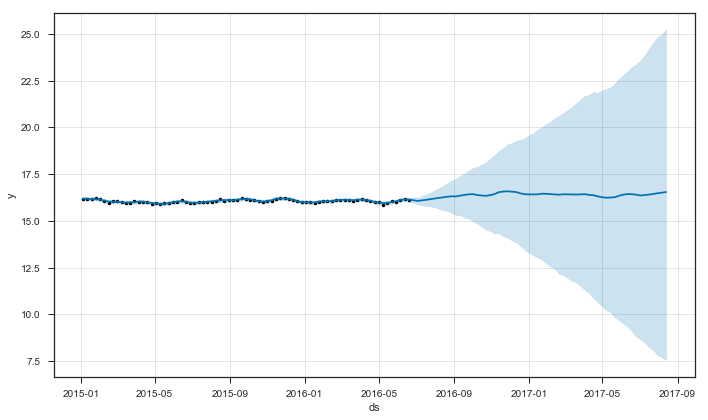

In [64]:

m2 = Prophet(growth='linear',
             changepoint_prior_scale=0.09,
             #n_changepoints=7,
             #changepoints= #List,
             #yearly_seasonality=boolean
             weekly_seasonality=False,
             mcmc_samples=500,
             holidays=holiday_df, # To use the holidays in the model, pass it to the model via the 'holidays' keyword
             holidays_prior_scale=4,
             seasonality_prior_scale=5,
             uncertainty_samples=500,
             interval_width=0.95,
            ).fit(dataset)
future2 = m2.make_future_dataframe(periods=60, freq='W-SUN')
forecast2 = m2.predict(future2)
m2.plot(forecast2); # New forecast based on model that includes holidays

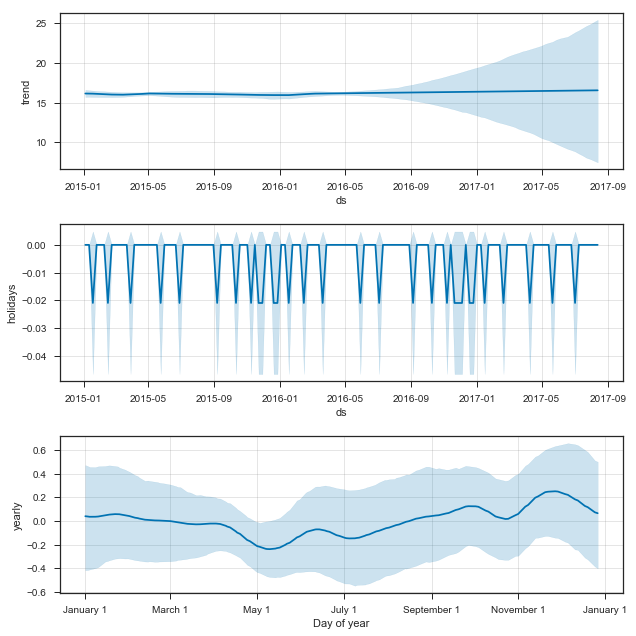

In [65]:
# Various components of m2 (w/ holidays added)
m2.plot_components(forecast2);

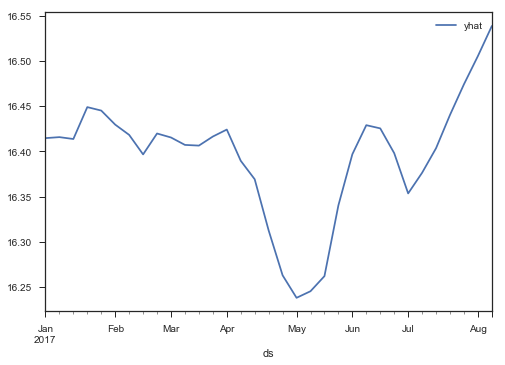

In [70]:
# Review the predictions of the future
import datetime
fig1 = forecast2[forecast2.ds > datetime.date(2016, 12, 31)]
fig1.plot(x='ds', y='yhat');

In [76]:
# Test the accuracy of the results from the 2 forecasted time-series
# Adj. R Square & Cross-validation is the best way to evaluate models used for prediction. 
# Here you divide your data set into two group (train and validate). 
# A simple mean squared difference between the observed and predicted values give you a measure for the prediction accuracy.

![Adj. R Square](https://www.analyticsvidhya.com/wp-content/uploads/2015/10/Adjusted-R-Squre.png)

In [71]:
forecast2

,ds,t,trend,seasonal_lower,seasonal_upper,trend_lower,trend_upper,yhat_lower,yhat_upper,fed_holiday,fed_holiday_lower,fed_holiday_upper,yearly,yearly_lower,yearly_upper,seasonal,yhat
0,2015-01-04,0.000,16.149,-0.411,0.458,15.722,16.609,16.076,16.296,0.000,0.000,0.000,0.036,-0.411,0.458,0.036,16.184
1,2015-01-11,0.013,16.140,-0.382,0.464,15.732,16.558,16.091,16.275,0.000,0.000,0.000,0.040,-0.382,0.464,0.040,16.180
2,2015-01-18,0.026,16.131,-0.364,0.445,15.718,16.513,16.064,16.259,-0.021,-0.047,0.005,0.054,-0.333,0.472,0.033,16.165
3,2015-01-25,0.039,16.108,-0.315,0.452,15.718,16.471,16.079,16.256,0.000,0.000,0.000,0.057,-0.315,0.452,0.057,16.165
4,2015-02-01,0.053,16.084,-0.320,0.418,15.712,16.446,16.030,16.220,0.000,0.000,0.000,0.042,-0.320,0.418,0.042,16.125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132,2017-07-16,1.737,16.529,-0.539,0.278,8.361,24.368,8.250,24.202,0.000,0.000,0.000,-0.125,-0.539,0.278,-0.125,16.404
133,2017-07-23,1.750,16.534,-0.508,0.306,8.080,24.645,8.077,24.530,0.000,0.000,0.000,-0.094,-0.508,0.306,-0.094,16.440
134,2017-07-30,1.763,16.540,-0.467,0.348,7.919,24.864,7.815,24.836,0.000,0.000,0.000,-0.065,-0.467,0.348,-0.065,16.474
135,2017-08-06,1.776,16.545,-0.445,0.357,7.712,25.143,7.697,24.984,0.000,0.000,0.000,-0.040,-0.445,0.357,-0.040,16.506


#### Interpret ####